

















































































































# Enhancing Urban Seismic Resilience: Integrating AI and Monte Carlo Methods for Real-Time Hazard Prediction

## Google Colab Requirement
In the Google Colab notebook, this section is included to ensure the necessary environment for the project is set up. The `pygmm` package, necessary for ground motion modeling, and the `rasterio` package, essential for managing geospatial raster data, are installed. Additionally, the `wntr` package, used for hydraulic simulations of water distribution systems, is also installed.\
Google Drive is then mounted to provide access to persistent storage for file operations, and the project directory is added to the Python path to facilitate the easy import of custom modules. This configuration is essential for the seamless execution of the project.

In [1]:
!pip install pygmm
!pip install rasterio
!pip install wntr
!pip install geopandas matplotlib contextily

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
base_path = '/content/drive/My Drive/Colab Notebooks/Enhancing Urban Seismic Resilience: Integrating AI and Monte Carlo Methods for Real-Time Hazard Prediction'
sys.path.append(base_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.3/956.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.8 MB/s eta 0:00:00
Mounted at /content/drive


## 1- Prerequisites
In addition to the main notebook, there are six essential classes from their respective modules, setting the stage for conducting a probabilistic seismic hazard analysis (PSHA):

#### **SeismicSourceSimulator:**
Imported from `seismic_source_simulator`, this class plays a critical role in the initial stages of the PSHA by generating seismic source characteristics using Monte Carlo simulations. It meticulously creates a comprehensive dataset of potential seismic events by randomly sampling from predefined probability distributions for key seismic parameters.

#### **InitialSetup:**
This class, imported from `initial_setup`, is responsible for initializing the PSHA process. It reads and processes the input data related to site and seismic source characteristics.
The class ensures that all necessary information is correctly loaded and formatted for subsequent analysis steps.

#### **EarquakeGenerator:**
Imported from `earthquake_generator`, this class is key to generating earthquake scenarios. It utilizes the data processed by InitialSetup to create a series of hypothetical earthquake events using Monte Carlo simulation method. This involves determining magnitudes based on a Magnitude-Frequency Distribution (MFD), assigning magnitudes to specific seismic sources, and calculating ground motion paramaters using a chosen Ground Motion Equation (GME) model. This class is crucial for simulating the diverse range of potential seismic events that could impact the study area.

#### **HydraulicSimulator:**
Imported from `hydraulic_simulator`, this module is essential for simulating the hydraulic behavior of water distribution systems under various scenarios, including seismic events. It uses *wntr* Python package to predict how disruptions like pipe breaks or pressure losses affect water serviceability across an urban network.

#### **PopulationCalculator:**
Imported from `population_calculator`, this module calculates the impact of seismic events on populations connected to specific nodes in a water distribution system. It evaluates how service disruptions due to seismic damage affect the water supply to residential and commercial areas, thereby estimating the number of people impacted.

#### **HydraulicDataProcessor:**
This module, imported from `data_processor`, is designed to facilitate complex data processing tasks associated with hydraulic simulations of water distribution systems. It integrates hydraulic behavior simulation using WNTR with additional seismic and demographic data to produce a comprehensive DataFrame. This DataFrame includes hydraulic characteristics such as pressures and pipe dimensions, as well as seismic impact data and population metrics. This module is crucial for providing the necessary data integration for advanced analysis and AI modeling, aiming to predict the resilience of urban water systems against seismic events.



In [2]:
from modules.seismic_source_simulator import SeismicSourceSimulator
from modules.initial_setup import InitialSetup
from modules.earthquake_generator import EarthquakeGenerator
from modules.hydraulic_simulator import HydraulicSimulator
from modules.population_calculator import PopulationCalculator
from modules.data_processor import DataProcessor
from modules.ai_model_developer import AIModelDeveloper

from modules.visualization import Visualization

## 2- Monte Carlo Simulation for Seismic Source Characterization
This section is dedicated to generating seismic source characteristics using Monte Carlo simulations. The aim is to create a robust dataset of potential seismic events by sampling from specific probability distributions for key seismic parameters. These parameters and their corresponding distributions include:

- **Magnitude (min and max)**: Modeled using either a truncated Gaussian or an exponential distribution to reflect the natural occurrence and tail behavior of seismic magnitudes.
- **Depth**: Utilizes either a uniform or Gaussian distribution based on regional seismic data that highlights typical depth ranges or variability.
- **Latitude and Longitude**: Employ a uniform distribution within the predefined bounds of the seismic region of interest to capture geographical variability.
- **Dip and Strike**: Modeled with either a uniform or Beta distribution, depending on the precision and variability observed in geological data.
- **Mechanism and Event Type**: Categorical distributions are used, set based on the proportionality observed in historical seismic data.

Each iteration of the simulation generates a comprehensive set of seismic source characteristics, accounting for the inherent variability and uncertainty in seismic activity. These characteristics serve as critical inputs for subsequent PSHA and are essential for accurately modeling and predicting seismic impacts on urban infrastructure. The outcomes of these simulations are methodically saved in a JSON format, ensuring easy integration and reuse in further analyses throughout the notebook. This approach not only adheres to but also leverages historical and empirical seismic data to enhance the reliability of our seismic risk assessments.



In [3]:
source_data_path = f'{base_path}/inputs/source_data.json'

seismic_source_simulator = SeismicSourceSimulator(source_data_path, num_faults=5, m_min=5.5, m_max=7.5, lat_range=(35.0, 35.5), lon_range=(-90.5, -89.5), depth_range=(0, 10), dip_range=(80, 85), strike_range=(20, 30))
source_data = seismic_source_simulator.generate_all_sources()
seismic_source_simulator.save_to_json(source_data)

## 3- Data Loading and Processing
In this section, essential data for the PSHA and hydraulic simulation of water distribution system are loaded and processed.
*In this notebook, we use the Shelby County WDS as our case study.*

##### **Site Data**
Site data are sourced from a CSV file, comprising:
- *IDs*
- Geographic coordinates (*latitude* and *longitude* in degrees)
- *Depths* in kilometers
- *Vs30* values in meters per second (acceptable range is between 150 to 1500 m/s)
- Soil or rock *conditions*

##### **Seismic Source Data**
In the context of WDSs, there are primarily two types of seismic hazards: (1) *transient ground deformation* (TGD), which occurs due to ground shaking, and (2) *permanent ground deformation* (PGD), which arises from fault displacement, landslides, or liquefaction-induced ground failures. In this study, we specifically focus on the TGD hazard.\
The necessary seismic data for TGD hazard assessment includes the following:

- **Geographic coordinates**: *Latitude* and *longitude* in degrees.
- **Depth**: The depth of the earthquake's focus in km.
- **Range of potential magnitudes**: *Minimum* and *maximum* magnitudes with an acceptable range between 3 to 8.5.
- **Recurrence rates**: Describes the frequency at which similar seismic events are expected to recur.
- **Fault mechanisms**: Categorized as *Strike-Slip (SS)*, *Normal Slip (NS)*, or *Reverse Slip (RS)*.
- **Dip**: Refers to the angle of the fault plane relative to the horizontal, measured in degrees.
- **Event type**: Classifies seismic events by their geological characteristics, typically as *interface* or *intraslab*, describing the tectonic interaction at play.

##### **Water Distribution System Data:**
WDS data consists of various attributes related to the water distribution network and is primarily sourced from the [**IN-CORE platform**](https://incore.ncsa.illinois.edu/).

* **Nodal Attributes:** Demand and geolocation (latitude/longitude) for each network node.
* **Pipeline Attributes:** Diameter and length of all pipelines.
* **Network Layout:** Spatial representation of pipes, nodes, tanks, and pumps.
* **EPANET File:** A pre-configured EPANET file for accurate water flow and pressure simulations.







In [4]:
site_data_path   = f'{base_path}/inputs/site_data.csv'
epanet_file_path = f'{base_path}/inputs/shelby_county_epanet.inp'

census_file_path      = f'{base_path}/inputs/shapefiles/shelby_county_census_tracts.shp'
water_nodes_file_path = f'{base_path}/inputs/shapefiles/shelby_county_water_nodes.shp'
water_pipes_file_path = f'{base_path}/inputs/shapefiles/shelby_county_water_pipes.shp'

setup = InitialSetup(source_data_path, site_data_path)

## 3- Probabilistic Seismic Hazard Analysis
This section conducts a **probabilistic seismic hazard analysis (PSHA)**, specifically tailored for **buildings** and **distributed lifeline systems**, such as power grids, water supply networks, and transportation systems. It considers the **spatial correlation** between infrastructural components, enabling a more realistic and detailed assessment of seismic hazards. The codes integrate data processing, scenario generation, and seismic hazard visualization.

The `EarthquakeGenerator` class facilitates the process of simulating earthquake events through a series of defined steps:  
It starts by generating magnitudes using the **Magnitude-Frequency-Distribution** (MFD), with the *Gutenberg-Richter law*$^{1}$ currently being the only supported method.  
Each magnitude is then assigned to a specific seismic source following Bayes’ theorem. For determining **ground-motion parameters**, the class utilizes the **PYGMM package**, with the **Boore, Stewart, Seyhan, and Atkinson (2014)**$^{2}$ model as the sole option supported, as outlined in the [PYGMM documentation](https://readthedocs.org/projects/pygmm/downloads/pdf/dev/)$^{3}$.  
The class normalizes inter-event residuals using univariate normal distribution data and accounts for variability within a single seismic event through intra-event residuals.  
Lastly, it calculates the Intensity Measure (IM) for each scenario, focusing on Peak Ground Acceleration (PGA) in units of _g_, Spectral Acceleration (SA) in units of _g_ applicable at different periods, and Peak Ground Velocity (PGV) in units of _cm/sec_.

<hr>
$^{1}$ <small> Gutenberg, B., & Richter, C. F. (1944). Frequency of earthquakes in California. Bulletin of the Seismological society of America, 34(4), 185-188.</small>

$^{2}$ <small> David M Boore, Jonathan P Stewart, Emel Seyhan, and Gail M Atkinson. (2014). NGA-West2 equations for predicting pga, pgv, and 5% damped psa for shallow crustal earthquakes. Earthquake Spectra, 30(3):1057–1085. </small>

$^{3}$ <small>Kottke, A. (2020). pygmm Documentation. </small>

In [5]:
magnitude_frequency_distribution = 'gr_recurrence_law'
ground_motion_equation_model     = 'AbrahamsonSilvaKamai2014' #'BooreStewartSeyhanAtkinson2014' #'AbrahamsonGregorAddo2016'

# Consider reference velocity as 1180 m/s
earthquake_generator = EarthquakeGenerator(setup, magnitude_frequency_distribution, ground_motion_equation_model, use_reference_velocity=True, reference_velocity=1180)

scenarios_dict, scenarios_df = earthquake_generator.generate_earthquake_objects(num_scenarios=100)

## 4- Assessing the Reliability of Water Distribution Systems to Seismic Hazards
This section examines the resilience of water distribution systems (WDS) specifically in relation to seismic activities affecting pipelines. Utilizing the [**WNTR package**](https://usepa.github.io/WNTR/), we focus our simulations exclusively on the earthquake impacts on pipelines within the WDS infrastructure. Our analysis aims to uncover vulnerabilities in pipeline integrity and assess the system's capacity to maintain water supply after seismic events. By conducting hydraulic simulations that integrate seismic data, we provide insights into targeted strategies for enhancing the resilience of pipelines in water distribution networks.

##### **Setting Up the Water Distribution System Model**
The hydraulic demand model in WNTR package is set to Pressure-Dependent Demand (PDD), which adjusts water demand based on the available pressure at each node.

##### **Analyzing Seismic Vulnerability of Pipelines**
Based on the American Lifelines Alliance (ALA) guidelines **(ALA, 2001)**$^{2}$, the repair rate (RR) is a key indicator to quantify the potential impact of seismic events on the pipeline infrastructure. RR represents the expected number of repairs needed per unit length of pipeline per year due to seismic hazards. In this study, we utilized the WNTR package to estimate the RR for each pipeline, employing the following regression model:
$$RR = C \times 0.000241 \times PGV$$
Where:
- $C$ is the correction factor, maps pipe characteristics to weights.
- $PGV$ is the peak ground velocity (m/s).
- $RR$ is the estimated number of repairs per meter per year due to TGD.

After estimating the repair rate, we determine the probability of failure for each pipeline by considering that even one damage is a failure. The probability of failure is calculated as the complement of the probability of zero failures, which follows a Poisson distribution:
$$P_f = 1 - e^{-RR \times \text{Length}}$$
Where:
- $P_f$ is the probability of failure of the pipeline.
- $RR$ is the repair rate of the pipeline.
- $\text{Length}$ is the length of the pipeline.

If the pipeline is deemed to fail (i.e., a random number between 0 and 1 is less than $P_f$), we then predict the number of damages per unit length of the pipeline using a Poisson random number with a mean equal to the repair rate **(Su et al. 1987$^{3}$; Fragiadakis and Christodoulou 2014$^{4}$; Farahmandfar et al. 2016$^{5}$)**.

The number of damages ($N_{\text{damages}}$) should then be divided into leaks ($N_{LKS}$) and breaks ($N_{BKS}$). In general, 15–20% of those damages result in breaks, while the rest represent leaks **(Hwang and Shinozuka 1998)**$^{6}$.
$$ N_{LKS} = 0.85 \times N_{damages} $$
$$ N_{BKS} = 0.15 \times N_{damages} $$

Ultimately, to model the damage, we add an orifice with the following opening area to the damaged pipeline **(Farahmandfar and Piratla, 2017)**$^{7}$:
$$ A_T = (0.03 \times N_{LKS} + 0.2 \times N_{BKS}) \times A $$
Where $A_T$ is the total orifice area and $A$ is the pipeline cross-sectional area.
### 4-5- Running Hydraulic Simultion for the Damaged WDS
In this section, we perform a hydraulic simulation of the WDS using the WNTRSimulator. The simulation results are then used to calculate the serviceability of different components in the WDS.

Serviceability is a measure of how well the system is able to meet the required demands after an event such as an earthquake. It is calculated differently for tanks, junctions, and pumps:

- **Tanks:** Serviceability is defined as the ratio of the new average tank level to the original tank level. This indicates how much water is available in the tank compared to its initial level.

- **Junctions:** Serviceability is the ratio of the average satisfied demand to the required demand at each junction. This shows how well the junctions are able to meet the water demand.

- **Pumps:** Serviceability is based on the operational status of the pumps. It is a binary value indicating whether the pump is operational (1) or not (0).

<hr>
$^{1}$ <small> Klise, K. A., Bynum, M., Moriarty, D., & Murray, R. (2017). WNTR: An EPANET Toolkit for Water Network Research. Comp. Environ. Urban Syst., 67, 70–80.</small>

$^{2}$ <small> ALA (American Lifelines Alliance). (2001). Seismic fragility formulations for water systems guideline and appendices.</small>

$^{3}$ <small> Su, Y. C., Mays, L. W., Duan, N., and Lansey, K. E. (1987). Reliability based optimization model for water distribution systems. J. Hydraul. Eng., 1539–1556.</small>

$^{4}$ <small> Fragiadakis, M., and Christodoulou, S. E. (2014). “Seismic reliability assessment of urban water networks.” Earthquake Eng. Struct. Dyn., 43(3), 357–374. </small>

$^{5}$ <small>Farahmandfar, Z., Piratla, K. R. & Andrus, R. D Resilience evaluation of water supply systems against seismic hazards.
ASCE Journal of Pipeline Systems Engineering and Practice 8 (1), 04016014. </small>

$^{6}$ <small>Hwang, H. H., Lin, H., and Shinozuka, M. (1998). “Seismic performance assessment of water delivery systems.” J. Infrastruct. Syst., 10.1061/(ASCE)1076-0342(1998)4:3(118), 118–125. </small>

$^{7}$ <small> Farahmandfar, Z., & Piratla, K. R. (2017). Resilience-based water main rehabilitation planning in a multi-hazard context. Journal of Water Supply: Research and Technology—AQUA, 66(8), 651-664.</small>






In [6]:
duration = 24 * 3600  # hours
leak_start_time = 5 * 3600; leak_end_time = 15 * 3600 # hours
minimum_pressure = 5; required_pressure = 20 # meters of water

In [7]:
hydraulic_simulator = HydraulicSimulator(epanet_file_path, scenarios_df)
serviceability_df   = hydraulic_simulator.run_hydraulic_simulation(duration, leak_start_time, leak_end_time, minimum_pressure, required_pressure)

## 5- Quantifying Population Impact of Earthquake on Water Distribution Nodes
In this section, we explore the impact of earthquakes on the population served by water distribution nodes. We start by obtaining population data for each census tract in Shelby County, TN, from the [2020 Shelby County Census Tract Population](https://shelbycounty.maps.arcgis.com/apps/webappviewer/index.html?id=1e71e2791dad491bbf007997c20593c1). This data is then integrated into the shapefile of Shelby County census tracts for analysis. Using **spatial analysis** techniques, we determine the population served by each water node within the distribution system. Subsequently, we calculate the population impacted by the earthquake as the product of (1 - serviceability) and the population served by each water node. This metric provides an estimate of the population affected by the earthquake-induced disruptions in the water distribution network.




In [8]:
population_calculator = PopulationCalculator(census_file_path, water_nodes_file_path, scenarios_df, serviceability_df)
population_df = population_calculator.calculate_population_impacted()

## 6- Integration of Seismic, Hydraulic, and Population Data

This section focuses on integrating essential datasets: seismic hazard data, hydraulic simulation results, and population impact metrics. The consolidated data is crucial for developing AI models that predict and enhance the seismic resilience of urban water systems.

The resulting DataFrame from this integration will include the following information:
- **Node ID**: Identifier for each node in the water distribution system.
- **Total Incoming and Outgoing Pipe Counts**: Reflects the connectivity of each node.
- **Average Diameter and Total Length of Connecting Pipes**: Provides insights into the capacity and scale of the infrastructure.
- **Material Mode**: The most common material of the pipes connected to each node.
- **Maximum and Minimum Pressures**: Essential for assessing the operational range and stability under different scenarios.
- **Serviceability Index**: A measure of how effectively a node can meet water demand post-earthquake.
- **Population Served and Population Impact Factor**: Metrics to evaluate the direct human impact of service disruptions.
- **Seismic Data (PGA, PGV)**: Indicators of the earthquake's intensity at each node, crucial for damage assessment and response planning.

This integrated dataset is structured to support the development and training of AI models that can provide actionable insights into enhancing the resilience of water distribution systems against seismic events.

In [9]:
data_processor = DataProcessor(epanet_file_path, scenarios_df, serviceability_df, population_df)
combined_df    = data_processor.generate_combined_dataframe()

## 7- AI Model Development

In this section, we focus on the development and training of a machine learning model that predicts the serviceability of water nodes following seismic events, using the consolidated dataset described previously. We employ a Random Forest Regressor for its robustness and efficacy in handling complex datasets with non-linear relationships among variables. The model utilizes key features such as magnitude, distance, PGA, PGV, total incoming and outgoing pipe counts, average diameter and total length of connecting pipes, and maximum and minimum pressures, which are crucial for assessing the impact of seismic activities on water distribution systems.

The training process involves adjusting parameters to minimize the Mean Squared Error (MSE), which gauges the model's accuracy in predicting serviceability. A lower MSE indicates that the model is performing well and capturing the essential trends in the data effectively. Post training, we conduct a feature importance analysis to identify the variables that significantly influence the resilience of the water distribution system. This analysis not only informs us about the critical aspects of the infrastructure that need reinforcement but also aids in prioritizing mitigation strategies.

Furthermore, the predictive capability of the model is tested by applying it to simulate the impact of hypothetical new seismic events. This predictive performance is crucial for real-time decision-making, enabling urban planners and emergency management teams to deploy more effective strategies based on anticipated serviceability levels. All procedures for developing, training, and evaluating the AI model are encapsulated within the `AI_model_developer` module, ensuring our approach is reproducible, scalable, and ready for practical application to enhance urban seismic resilience.


In [10]:
features = [
        'magnitude', 'distance', 'PGA', 'PGV', 'Total Incoming Pipe Count',
        'Total Outgoing Pipe Count', 'Sum of Pipe Lengths', 'Maximum Pressure', 'Minimum Pressure'
]
target = 'serviceability'
ai_model_developer = AIModelDeveloper(combined_df, features, target)
ai_model_developer.split_data()
ai_model_developer.train_model()
mse = ai_model_developer.evaluate_model()
importances = ai_model_developer.get_feature_importances()

## 8- Visualization

This section illustrates the outcomes and insights derived from the analysis. Utilizing the `Visualization` module, we generate several key graphical representations: Seismic Hazard Contour Maps, Serviceability Maps, and Feature Importance Charts. These visual tools highlight the geographic distribution of seismic risks, the operational status of water distribution nodes post-earthquake, and the relative importance of various predictive features. Each visualization is designed to aid decision-makers and stakeholders in quickly assessing the areas of concern and understanding the factors influencing the system's resilience.


In [11]:
visualization = Visualization(setup, scenarios_dict, return_period=50)

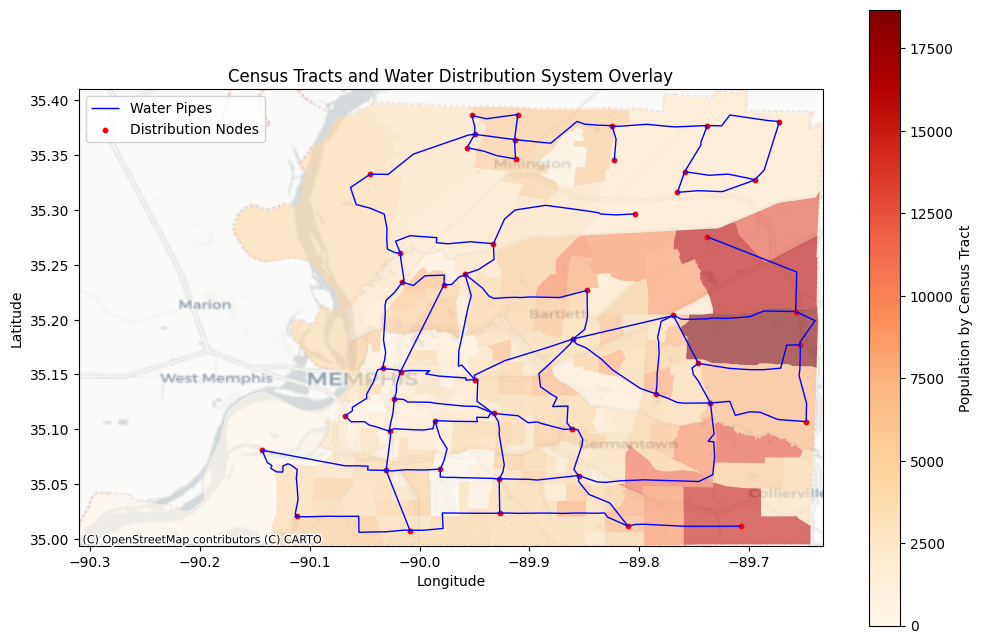

In [12]:
visualization.plot_infrastructure_map(census_file_path, water_nodes_file_path, water_pipes_file_path)

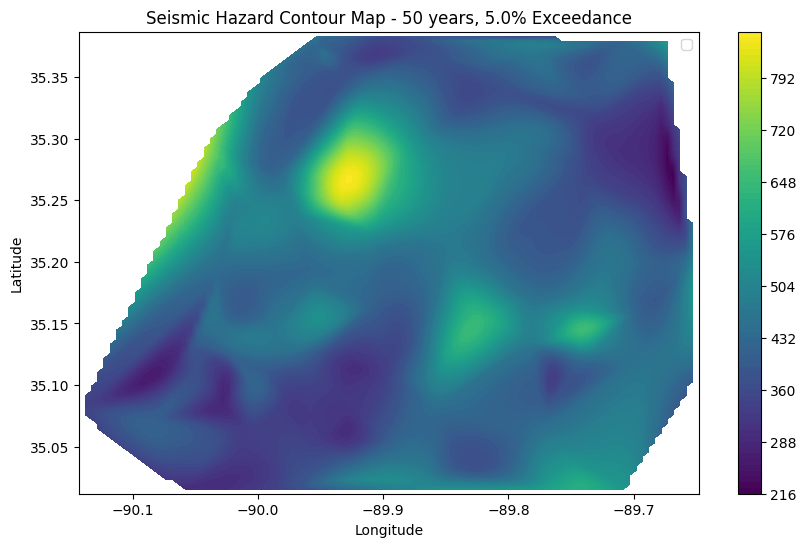

In [13]:
visualization.plot_contour_map(exceedance_probability=0.05, ground_motion_type='PGV')

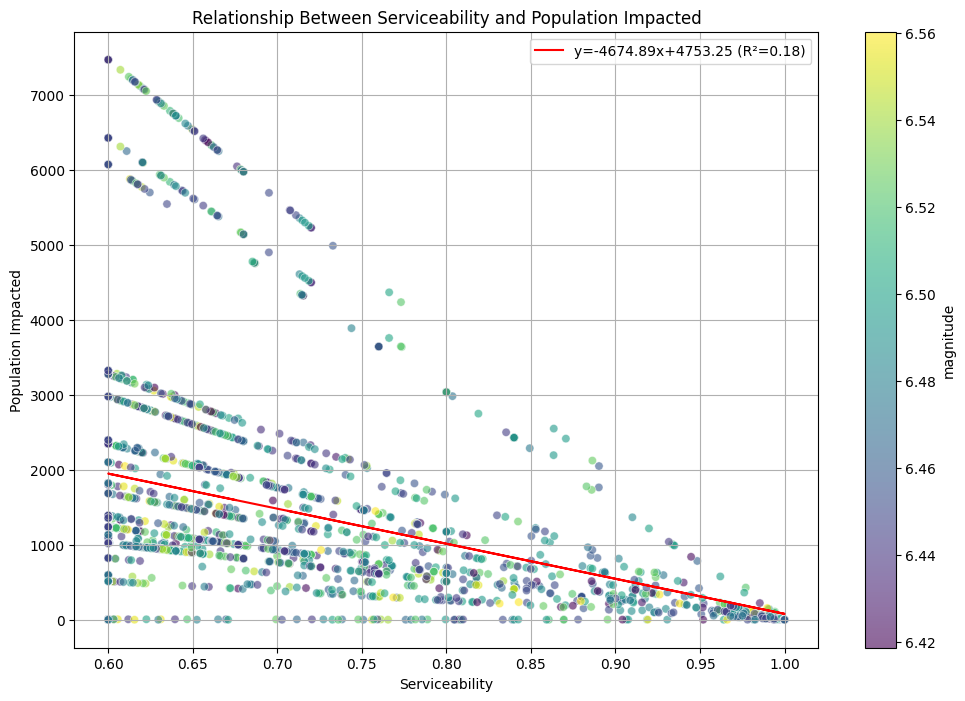

In [14]:
visualization.plot_population_impacts(combined_df, 'serviceability', color_by='magnitude')

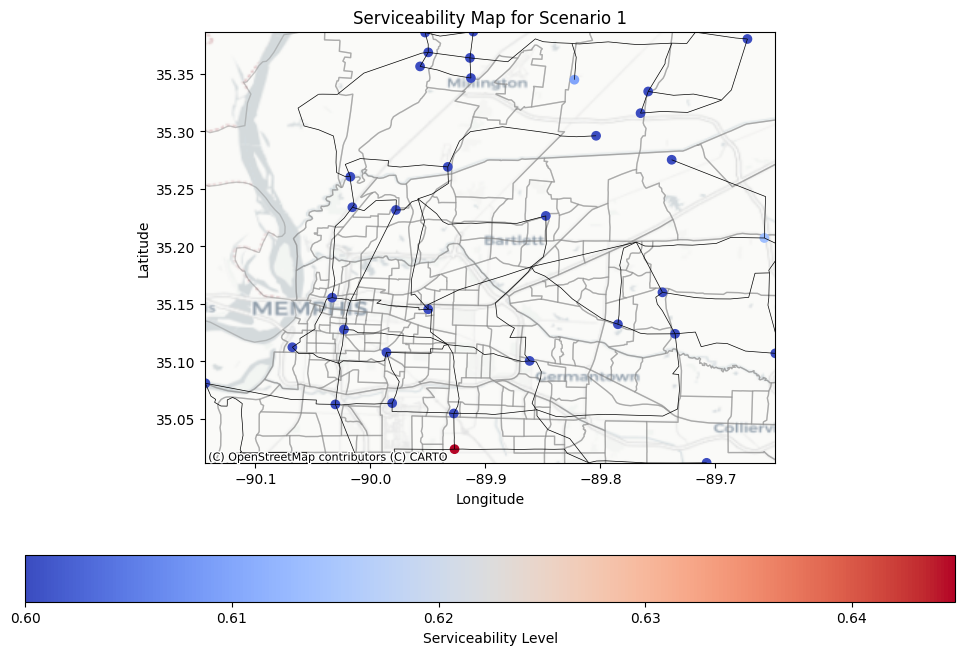

In [15]:
visualization.plot_serviceability_map(census_file_path, water_nodes_file_path, water_pipes_file_path, serviceability_df, 1)

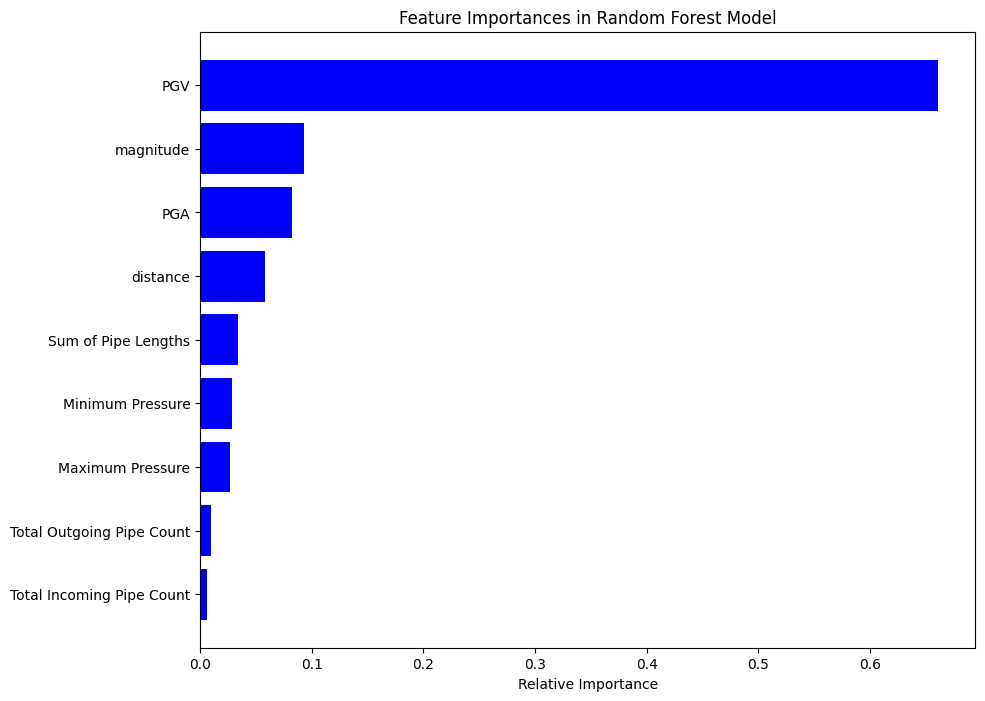

In [16]:
visualization.plot_feature_importances(importances, features)